In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
path = "canzoni-etichettate/IRMAS-TrainingData/"
path_3_class = "./canzoni-etichettate/3-classi/"

### Vengono calcolate le varie trasformazioni (CQT, Mel e Chromogram)

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

n_fft = 2048  # Dimensione della finestra FFT
hop_length = 512  # Passo della finestra
n_mels = 128  # Numero di bande Mel

def audio_to_spectrograms(file_path):
    # Carica il file audio
    y, sr = librosa.load(file_path, sr=None)
    
    # Calcola CQT
    C = librosa.cqt(y, sr=sr)
    C_db = librosa.amplitude_to_db(np.abs(C))
    
    # Calcola Mel-spettrogramma
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    
    # Calcola Cromagramma
    chroma = librosa.feature.chroma_stft(
        y=y, 
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length
    )
    
    # Ridimensiona la CQT alla stessa dimensione temporale del Mel-spettrogramma e del Chromagramma
    C_db = librosa.resample(C_db, orig_sr=C_db.shape[1], target_sr=mel_db.shape[1])
    
    return C_db, mel_db, chroma

def plot_spectrograms(C_db, mel_db, chroma, sr):
    # Crea una figura con tre subplot
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot CQT
    img1 = librosa.display.specshow(
        C_db,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='cqt_note',
        ax=axes[0]
    )
    axes[0].set_title('Constant-Q Transform (CQT) Spectrogram')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Note')
    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    
    # Plot Mel-spettrogramma
    img2 = librosa.display.specshow(
        mel_db,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        ax=axes[1]
    )
    axes[1].set_title('Mel Spectrogram')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Mel Frequency')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    
    # Plot Cromagramma
    img3 = librosa.display.specshow(
        chroma,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='chroma',
        ax=axes[2]
    )
    axes[2].set_title('Chromagram')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Pitch Class')
    fig.colorbar(img3, ax=axes[2])
    
    # Aggiusta il layout
    plt.tight_layout()
    plt.show()


### Preprocessamento dei dati per la rete neurale

In [4]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(data_dir):
    X_waveplot = []
    X_cqt = []
    X_mel = []
    X_chroma = []
    y = []
    class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for audio_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, audio_file)
            if os.path.isfile(file_path):
                C_db, mel_db, chroma = audio_to_spectrograms(file_path)
                waveplot, _ = librosa.load(file_path, sr=16000)
                X_waveplot.append(waveplot) 
                X_cqt.append(C_db)
                X_mel.append(mel_db)
                X_chroma.append(chroma)
                y.append(class_idx)

    X_waveplot = np.array(X_waveplot)
    X_cqt = np.array(X_cqt)
    X_mel = np.array(X_mel)
    X_chroma = np.array(X_chroma)
    y = np.array(y)
    return X_waveplot, X_cqt, X_mel, X_chroma, y, class_names

# Carica e preprocessa i dati
X_waveplot, X_cqt, X_mel, X_chroma, y, class_names = load_and_preprocess_data(path_3_class)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import KFold

def create_multi_input_model(input_shape_cqt, input_shape_mel, input_shape_chroma, input_shape_waveplot):
    # Branch per CQT
    input_cqt = Input(shape=input_shape_cqt)
    # Aggiungo il numero di canali, input richesto dallo strato convoluzionale
    x1 = Reshape(target_shape=(input_shape_cqt[0], input_shape_cqt[1], 1))(input_cqt)
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Branch per Mel-spettrogramma
    input_mel = Input(shape=input_shape_mel)
    x2 = Reshape(target_shape=(input_shape_mel[0], input_shape_mel[1], 1))(input_mel)
    x2 = Conv2D(32, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Branch per Cromagramma
    input_chroma = Input(shape=input_shape_chroma)
    x3 = Reshape(target_shape=(input_shape_chroma[0], input_shape_chroma[1], 1))(input_chroma)
    x3 = Conv2D(32, (3, 3), activation='relu')(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Conv2D(64, (3, 3), activation='relu')(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Flatten()(x3)

    # Branch per Waveplot (1D Conv)
    input_waveplot = Input(shape=input_shape_waveplot)
    x4 = Reshape(target_shape=(input_shape_waveplot[0], 1))(input_waveplot)  # Aggiungi una dimensione per il Conv1D
    x4 = Conv1D(32, 3, activation='relu')(x4)
    x4 = MaxPooling1D(2)(x4)
    x4 = Conv1D(64, 3, activation='relu')(x4)
    x4 = MaxPooling1D(2)(x4)
    x4 = Flatten()(x4)

    # Fusione
    concatenated = Concatenate()([x1, x2, x3, x4])
    x = Dense(128, activation='relu')(concatenated)
    x = Dropout(0.3)(x)
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=[input_cqt, input_mel, input_chroma, input_waveplot], outputs=outputs)
    return model

In [6]:
# Shuffle dei campioni
X_cqt, X_mel, X_chroma, X_waveplot, y = shuffle(X_cqt, X_mel, X_chroma, X_waveplot, y, random_state=42)

# Esecuzione della cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_cqt):
    X_train_cqt, X_val_cqt = X_cqt[train_index], X_cqt[val_index]
    X_train_mel, X_val_mel = X_mel[train_index], X_mel[val_index]
    X_train_chroma, X_val_chroma = X_chroma[train_index], X_chroma[val_index]
    X_train_waveplot, X_val_waveplot = X_waveplot[train_index], X_waveplot[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crea e compila il modello
    model = create_multi_input_model(
        input_shape_cqt=X_train_cqt[0].shape,
        input_shape_mel=X_train_mel[0].shape,
        input_shape_chroma=X_train_chroma[0].shape,
        input_shape_waveplot=X_train_waveplot[0].shape
    )
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Esegui il training e la valutazione del modello
    history = model.fit([X_train_cqt, X_train_mel, X_train_chroma, X_train_waveplot], y_train,
                       epochs=10, batch_size=32,
                       validation_data=([X_val_cqt, X_val_mel, X_val_chroma, X_val_waveplot], y_val))

    # Valuta il modello sui dati di test
    test_loss, test_acc = model.evaluate([X_val_cqt, X_val_mel, X_val_chroma, X_val_waveplot], y_val)
    print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/10
13/37 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4756 - loss: 175.5108

KeyboardInterrupt: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step
Test Accuracy: 0.6912
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.68       141
           1       0.64      0.52      0.57       114
           2       0.71      0.84      0.77       166

    accuracy                           0.69       421
   macro avg       0.68      0.67      0.67       421
weighted avg       0.69      0.69      0.69       421



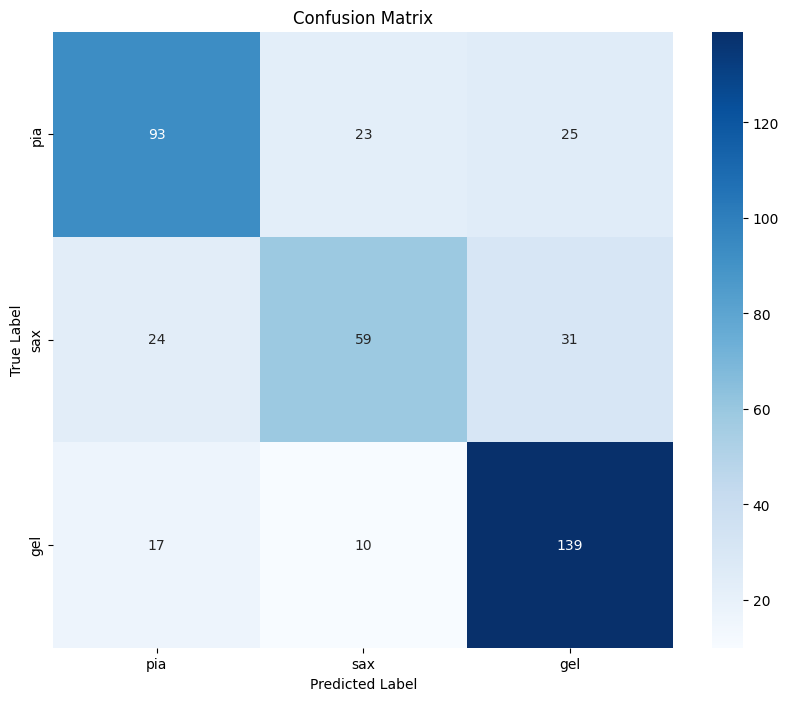

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ultima suddivisione del K-Fold per ottenere i dati di test finali
# Supponiamo che l'ultima esecuzione del ciclo 'for' nel K-Fold sia completata, quindi abbiamo:
# X_val_cqt, X_val_mel, X_val_chroma, y_val

# Calcola le predizioni finali sui dati di validazione dell'ultimo fold
predictions = model.predict([X_val_cqt, X_val_mel, X_val_chroma, X_val_waveplot])

# Converti le predizioni in etichette
predicted_labels = np.argmax(predictions, axis=1)

# Calcola l'accuracy sui dati di test dell'ultimo fold
accuracy = accuracy_score(y_val, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calcola e stampa il report di classificazione
class_report = classification_report(y_val, predicted_labels)
print("Classification Report:\n", class_report)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_val, predicted_labels)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def create_audio_model(input_shape_mel, input_shape_waveplot, num_classes):
    # Branch per Mel-spettrogramma
    input_mel = Input(shape=input_shape_mel)
    x1 = Reshape(target_shape=(input_shape_mel[0], input_shape_mel[1], 1))(input_mel)
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Branch per Waveplot (1D Conv)
    input_waveplot = Input(shape=input_shape_waveplot)
    x2 = Reshape(target_shape=(input_shape_waveplot[0], 1))(input_waveplot)  # Aggiungi una dimensione per il Conv1D
    x2 = Conv1D(32, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = Conv1D(64, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = Flatten()(x2)

    # Fusione
    concatenated = Concatenate()([x1, x2])
    x = Dense(128, activation='relu')(concatenated)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[input_mel, input_waveplot], outputs=outputs)
    return model

# Shuffle dei campioni
X_mel, X_waveplot, y = shuffle(X_mel, X_waveplot, y, random_state=42)

# Esecuzione della cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_mel):
    X_train_mel, X_val_mel = X_mel[train_index], X_mel[val_index]
    X_train_waveplot, X_val_waveplot = X_waveplot[train_index], X_waveplot[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crea e compila il modello
    model_mel = create_audio_model(
        input_shape_mel=X_train_mel[0].shape,
        input_shape_waveplot=X_train_waveplot[0].shape,
        num_classes=len(np.unique(y))  # Numero di classi basato sui target
    )
    model_mel.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Esegui il training e la valutazione del modello
    history = model_mel.fit([X_train_mel, X_train_waveplot], y_train,
                       epochs=10, batch_size=32,
                       validation_data=([X_val_mel, X_val_waveplot], y_val))

    # Valuta il modello sui dati di test
    test_loss, test_acc = model_mel.evaluate([X_val_mel, X_val_waveplot], y_val)
    print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4198 - loss: 110.7261 - val_accuracy: 0.5379 - val_loss: 0.9826
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 984ms/step - accuracy: 0.5884 - loss: 0.9201 - val_accuracy: 0.5995 - val_loss: 0.8596
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 885ms/step - accuracy: 0.7063 - loss: 0.6896 - val_accuracy: 0.5853 - val_loss: 0.8723
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 904ms/step - accuracy: 0.8227 - loss: 0.4555 - val_accuracy: 0.5545 - val_loss: 1.0474
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 928ms/step - accuracy: 0.9336 - loss: 0.2469 - val_accuracy: 0.5924 - val_loss: 1.2164
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 989ms/step - accuracy: 0.9693 - loss: 0.1253 - val_accuracy: 0.5332 - val_loss: 1.5026
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 935ms/step - accuracy: 0.9791 - loss: 0.0742 - val_accuracy: 0.5190 - val_loss: 1.3920
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 990ms/step - accuracy: 0.9761 - loss: 0.0775 - val_accur

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step
Test Accuracy: 0.6010
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.76      0.69       160
           1       0.41      0.30      0.35       113
           2       0.67      0.66      0.67       148

    accuracy                           0.60       421
   macro avg       0.57      0.57      0.57       421
weighted avg       0.59      0.60      0.59       421



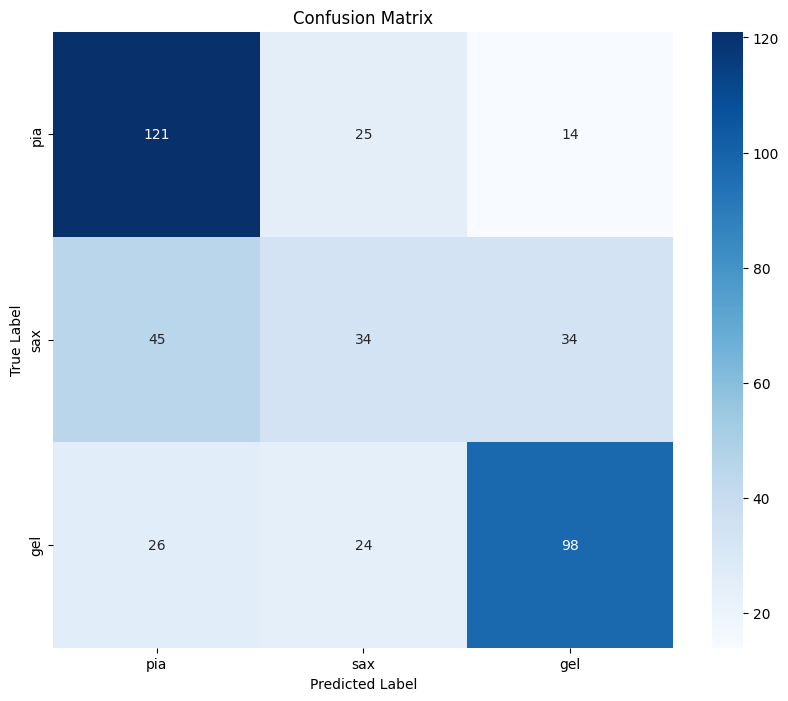

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ultima suddivisione del K-Fold per ottenere i dati di test finali
# Supponiamo che l'ultima esecuzione del ciclo 'for' nel K-Fold sia completata, quindi abbiamo:
# X_val_cqt, X_val_mel, X_val_chroma, y_val

# Calcola le predizioni finali sui dati di validazione dell'ultimo fold
predictions = model_mel.predict([X_val_mel, X_val_waveplot])

# Converti le predizioni in etichette
predicted_labels = np.argmax(predictions, axis=1)

# Calcola l'accuracy sui dati di test dell'ultimo fold
accuracy = accuracy_score(y_val, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calcola e stampa il report di classificazione
class_report = classification_report(y_val, predicted_labels)
print("Classification Report:\n", class_report)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_val, predicted_labels)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [7]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

def create_audio_model(input_shape_cqt, input_shape_waveplot, num_classes):
    # Branch per cqt-spettrogramma
    input_cqt= Input(shape=input_shape_cqt)
    x1 = Reshape(target_shape=(input_shape_cqt[0], input_shape_cqt[1], 1))(input_cqt)
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Branch per Waveplot (1D Conv)
    input_waveplot = Input(shape=input_shape_waveplot)
    x2 = Reshape(target_shape=(input_shape_waveplot[0], 1))(input_waveplot)  # Aggiungi una dimensione per il Conv1D
    x2 = Conv1D(32, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = Conv1D(64, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = Flatten()(x2)

    # Fusione
    concatenated = Concatenate()([x1, x2])
    x = Dense(128, activation='relu')(concatenated)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[input_cqt, input_waveplot], outputs=outputs)
    return model

# Shuffle dei campioni
X_cqt, X_waveplot, y = shuffle(X_cqt, X_waveplot, y, random_state=42)

y_one_hot = to_categorical(y, num_classes=len(np.unique(y)))

# Esecuzione della cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_cqt):
    X_train_cqt, X_val_cqt = X_cqt[train_index], X_cqt[val_index]
    X_train_waveplot, X_val_waveplot = X_waveplot[train_index], X_waveplot[val_index]
    y_train, y_val = y_one_hot[train_index], y_one_hot[val_index]

    # Crea e compila il modello
    model_cqt = create_audio_model(
        input_shape_cqt=X_train_cqt[0].shape,
        input_shape_waveplot=X_train_waveplot[0].shape,
        num_classes=len(np.unique(y))  # Numero di classi basato sui target
    )
    model_cqt.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Esegui il training e la valutazione del modello
    history = model_cqt.fit([X_train_cqt, X_train_waveplot], y_train,
                       epochs=10, batch_size=32,
                       validation_data=([X_val_cqt, X_val_waveplot], y_val))

    # Valuta il modello sui dati di test
    test_loss, test_acc = model_cqt.evaluate([X_val_cqt, X_val_waveplot], y_val)
    print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 932ms/step - accuracy: 0.6770 - loss: 28.7798 - val_accuracy: 0.8081 - val_loss: 0.4473
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 944ms/step - accuracy: 0.8330 - loss: 0.3780 - val_accuracy: 0.8418 - val_loss: 0.3653
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9003 - loss: 0.2626 - val_accuracy: 0.8485 - val_loss: 0.3334
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1018s 28s/step - accuracy: 0.9276 - loss: 0.1912 - val_accuracy: 0.8485 - val_loss: 0.3331
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 999ms/step - accuracy: 0.9617 - loss: 0.1202 - val_accuracy: 0.8552 - val_loss: 0.3581
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9874 - loss: 0.0716 - val_accuracy: 0.8485 - val_loss: 0.3428
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 961ms/step - accuracy: 0.9884 - loss: 0.0569 - val_accuracy: 0.8485 - val_loss: 0.3951
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 975ms/step - accuracy: 0.9972 - loss: 0.0279 - val_accuracy:

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Test Accuracy: 0.6788
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.71      0.67       139
           1       0.69      0.54      0.60        99
           2       0.72      0.74      0.73       148

    accuracy                           0.68       386
   macro avg       0.68      0.66      0.67       386
weighted avg       0.68      0.68      0.68       386



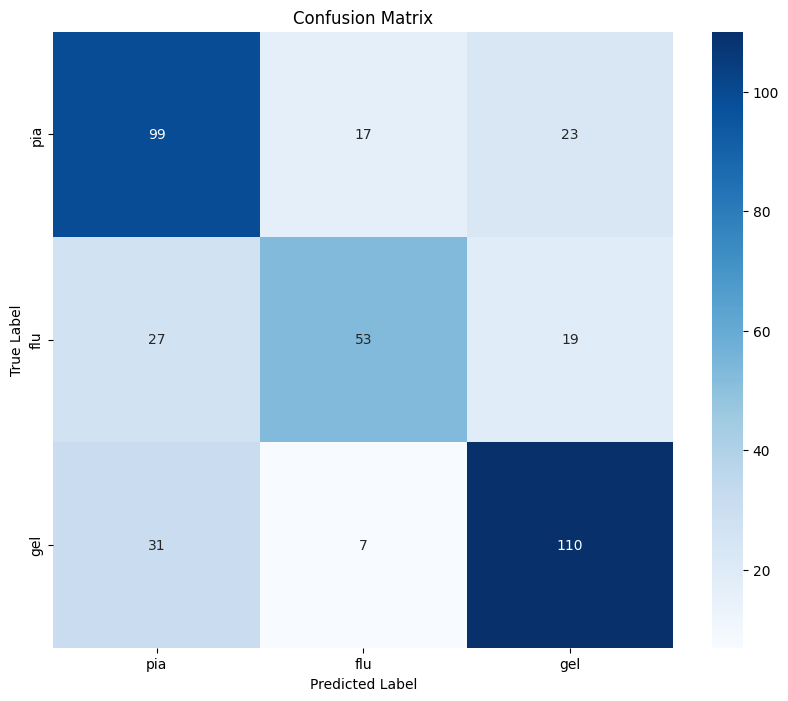

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola le predizioni finali sui dati di validazione dell'ultimo fold
predictions = model_cqt.predict([X_val_cqt, X_val_waveplot])

# Riporta le etichette in forma normale
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Converti le predizioni in etichette
predicted_labels = np.argmax(predictions, axis=1)

# Calcola l'accuracy sui dati di test dell'ultimo fold
accuracy = accuracy_score(y_val, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calcola e stampa il report di classificazione
class_report = classification_report(y_val, predicted_labels)
print("Classification Report:\n", class_report)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_val, predicted_labels)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

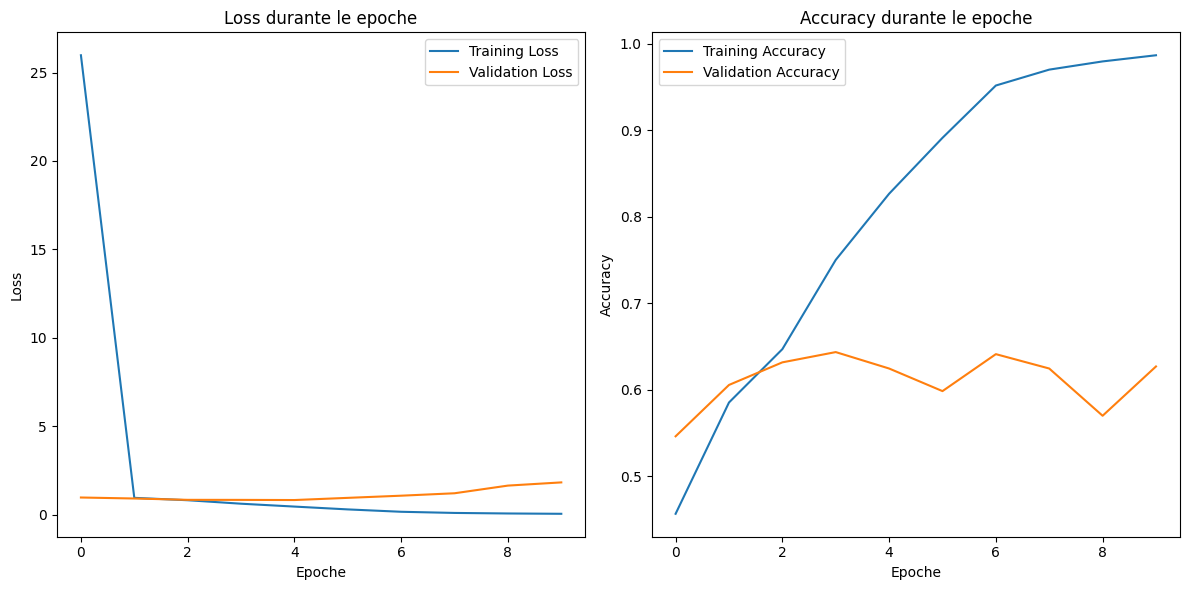

In [28]:
# Estrai i dati da 'history'
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Traccia il grafico della loss
plt.figure(figsize=(12, 6))

# Plot della loss (training vs validation)
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss durante le epoche')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

# Traccia il grafico dell'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy durante le epoche')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()

# Mostra i grafici
plt.tight_layout()
plt.show()

In [10]:
def create_audio_model(input_shape_chroma, input_shape_waveplot, num_classes):
    # Branch per chroma-spettrogramma
    input_chroma= Input(shape=input_shape_chroma)
    x1 = Reshape(target_shape=(input_shape_chroma[0], input_shape_chroma[1], 1))(input_chroma)
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Branch per Waveplot (1D Conv)
    input_waveplot = Input(shape=input_shape_waveplot)
    x2 = Reshape(target_shape=(input_shape_waveplot[0], 1))(input_waveplot)  # Aggiungi una dimensione per il Conv1D
    x2 = Conv1D(32, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = Conv1D(64, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = Flatten()(x2)

    # Fusione
    concatenated = Concatenate()([x1, x2])
    x = Dense(128, activation='relu')(concatenated)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[input_chroma, input_waveplot], outputs=outputs)
    return model

# Shuffle dei campioni
X_chroma, X_waveplot, y = shuffle(X_chroma, X_waveplot, y, random_state=42)

# Esecuzione della cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_chroma):
    X_train_chroma, X_val_chroma = X_chroma[train_index], X_chroma[val_index]
    X_train_waveplot, X_val_waveplot = X_waveplot[train_index], X_waveplot[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crea e compila il modello
    model_chroma = create_audio_model(
        input_shape_chroma=X_train_chroma[0].shape,
        input_shape_waveplot=X_train_waveplot[0].shape,
        num_classes=len(np.unique(y))  # Numero di classi basato sui target
    )
    model_chroma.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Esegui il training e la valutazione del modello
    history = model_chroma.fit([X_train_chroma, X_train_waveplot], y_train,
                       epochs=10, batch_size=32,
                       validation_data=([X_val_chroma, X_val_waveplot], y_val))

    # Valuta il modello sui dati di test
    test_loss, test_acc = model_chroma.evaluate([X_val_chroma, X_val_waveplot], y_val)
    print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 874ms/step - accuracy: 0.4631 - loss: 2.0059 - val_accuracy: 0.5640 - val_loss: 0.8906
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 934ms/step - accuracy: 0.6414 - loss: 0.8104 - val_accuracy: 0.6066 - val_loss: 0.8688
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7218 - loss: 0.6657 - val_accuracy: 0.6161 - val_loss: 0.8682
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8172 - loss: 0.4603 - val_accuracy: 0.6351 - val_loss: 1.0273
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 878ms/step - accuracy: 0.9148 - loss: 0.2617 - val_accuracy: 0.6066 - val_loss: 1.2199
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 766ms/step - accuracy: 0.9460 - loss: 0.1805 - val_accuracy: 0.6161 - val_loss: 1.3129
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.9817 - loss: 0.1020 - val_accuracy: 0.5995 - val_loss: 1.3146
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 806ms/step - accuracy: 0.9770 - loss: 0.0902 - val_accuracy: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
Test Accuracy: 0.5891
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.64      0.62       140
           1       0.53      0.34      0.42       126
           2       0.60      0.75      0.67       155

    accuracy                           0.59       421
   macro avg       0.58      0.58      0.57       421
weighted avg       0.58      0.59      0.58       421



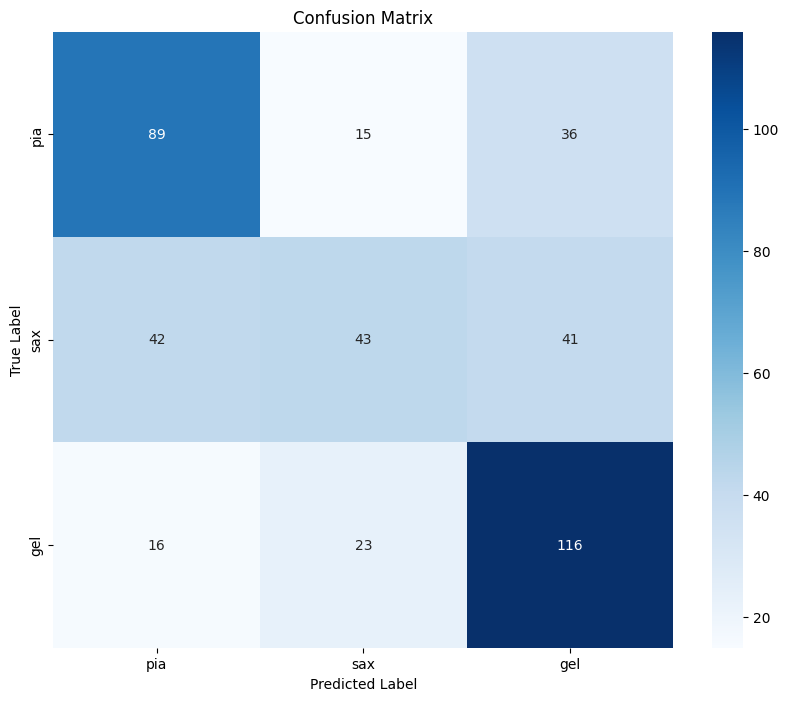

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola le predizioni finali sui dati di validazione dell'ultimo fold
predictions = model_chroma.predict([X_val_chroma, X_val_waveplot])

# Converti le predizioni in etichette
predicted_labels = np.argmax(predictions, axis=1)

# Calcola l'accuracy sui dati di test dell'ultimo fold
accuracy = accuracy_score(y_val, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Calcola e stampa il report di classificazione
class_report = classification_report(y_val, predicted_labels)
print("Classification Report:\n", class_report)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_val, predicted_labels)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()